# Trained on pooled dataset
- This has around 3000 images of our classes

In [1]:
# === Cell 1: Imports & Global Config ===
import os, re, json, random, math
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# Reproducibility
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# File paths
DATASET_CSV = "..\data\pooled_images.csv" # pooled dataset
LABELS_CSV  = "..\data\images.csv"        # our dataset
SUGGESTED_MAP_JSON = "suggested_mapping.json"
PROCESSED_CSV = "..\data\processed_dataset.csv"

print("Environment ready ✅")

Environment ready ✅


In [2]:
# === Cell 7: Import PyTorch and prepare transforms ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm

IMG_SIZE = 96  # 👈 Adjusted from 224 to 96
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


c:\Users\NSharma\anaconda3\envs\img_retrieval\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [3]:
# === Cell 8 (final): dataset class for your two sources ===
import os
from PIL import Image
from torch.utils.data import Dataset

# image directories
ROOT_LABELS_IMG_DIR  = r"..\data\images"
ROOT_DATASET_IMG_DIR = r"..\data\pooled_images"

class VTImageDataset(Dataset):
    def __init__(self, df, split='train', transform=None, source='dataset'):
        """
        Args:
            df: DataFrame (processed_dataset.csv or labels.csv)
            split: 'train' or 'val'
            transform: torchvision transforms
            source: 'dataset' or 'labels'
        """
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.transform = transform
        self.source = source
        
        # use appropriate image root
        self.img_root = ROOT_DATASET_IMG_DIR if source == 'dataset' else ROOT_LABELS_IMG_DIR
        
        # column names
        self.img_col = 'image_path'
        self.class_col = 'mapped_class' if source == 'dataset' else 'class_label'
        
        # build label dictionaries
        self.classes = sorted(self.df[self.class_col].unique().tolist())
        self.cls2idx = {c: i for i, c in enumerate(self.classes)}
        self.idx2cls = {i: c for c, i in self.cls2idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = os.path.basename(str(row[self.img_col]))
        full_path = os.path.join(self.img_root, filename)

        # load or create placeholder if missing
        if not os.path.exists(full_path):
            print(f"⚠️ Missing image at {full_path}")
            img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (128, 128, 128))
        else:
            img = Image.open(full_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.cls2idx[row[self.class_col]]
        return img, label


### Interchange between  dataset and labels to switch between pooled dataset and our dataset

✅ Loaded dataset dataset
Train: 2471 | Val: 620 | Classes: ['Cup', 'calculator', 'cap', 'earphones', 'keyboard', 'mouse', 'scissor', 'sneakers', 'umbrella', 'wristwatch']
Image root used: ..\data\pooled_images


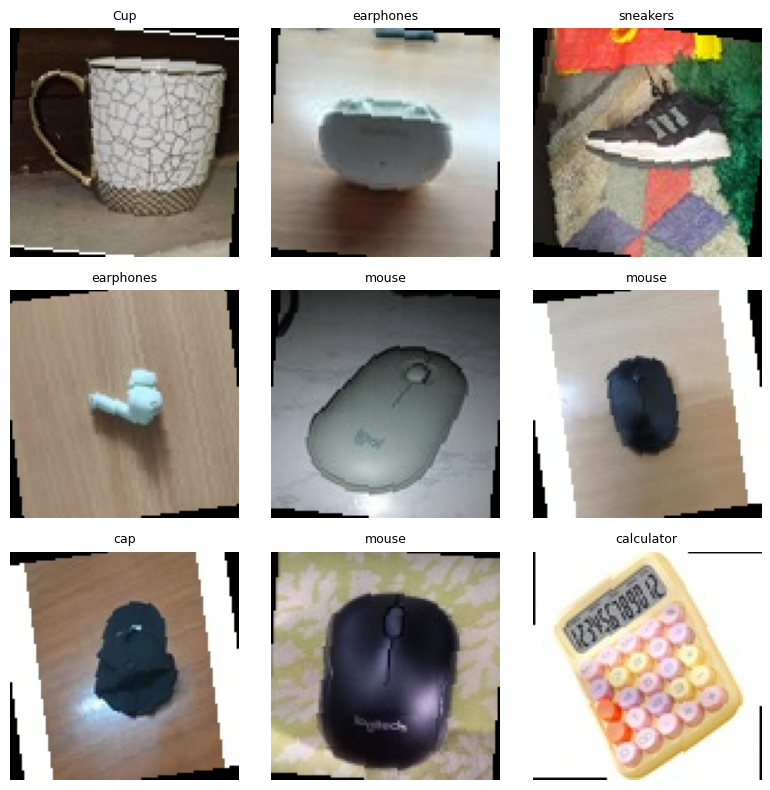

In [4]:
# === Cell 9 (final): DataLoaders + sample visualization ===
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np

# transforms for 96×96 images
train_tfms = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

val_tfms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

df_labels=pd.read_csv(r'..\data\images.csv')
df=pd.read_csv(r'..\data\processed_dataset.csv',encoding='latin1')
# Choose data source
DATA_SOURCE = 'dataset'   # 👈 'dataset' for processed_dataset.csv, 'labels' for images.csv
df_to_use = df_labels if DATA_SOURCE == 'labels' else df

# build datasets & dataloaders
train_ds = VTImageDataset(df_to_use, split='train', transform=train_tfms, source=DATA_SOURCE)
val_ds   = VTImageDataset(df_to_use, split='val',   transform=val_tfms, source=DATA_SOURCE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ Loaded {DATA_SOURCE} dataset")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Classes: {train_ds.classes}")
print("Image root used:", train_ds.img_root)

# --- visualize a few samples ---
def show_samples(dataset, n=9):
    idxs = random.sample(range(len(dataset)), min(n, len(dataset)))
    imgs, labels = zip(*[dataset[i] for i in idxs])
    imgs_np = [img.permute(1,2,0).numpy() * 0.5 + 0.5 for img in imgs]
    
    plt.figure(figsize=(8,8))
    for i in range(len(imgs_np)):
        plt.subplot(3,3,i+1)
        plt.imshow(np.clip(imgs_np[i],0,1))
        plt.title(dataset.idx2cls[labels[i]], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_ds)


✅ Per-class image counts:

split         train  val
mapped_class            
Cup             160   40
calculator      111   28
cap             160   40
earphones       319   80
keyboard        256   64
mouse           444  112
scissor          66   17
sneakers        480  120
umbrella         48   12
wristwatch      427  107

Total images: 3091


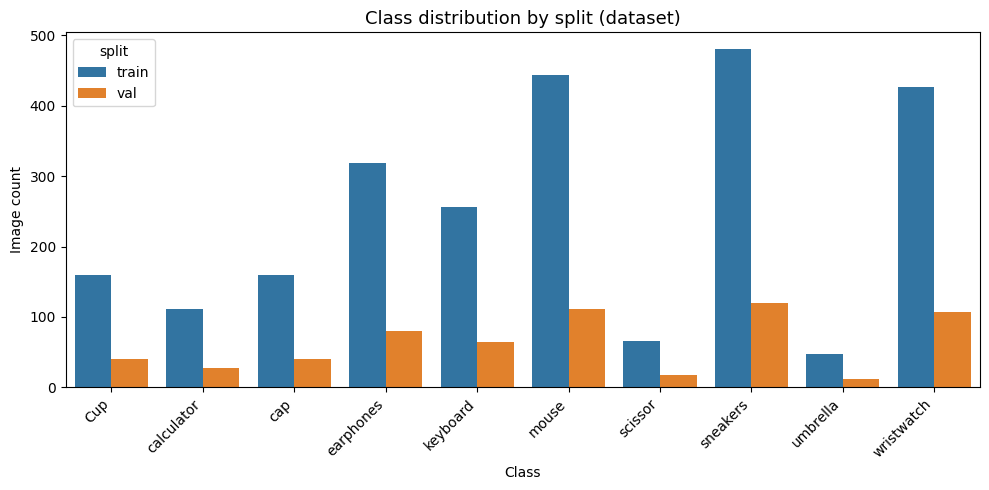

In [5]:
# === Cell 9b: Class distribution summary and plot ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pick correct DataFrame depending on source
df_to_use = df_labels if DATA_SOURCE == 'labels' else df

# quick sanity check
if "split" not in df_to_use.columns or "class_label" not in df_to_use.columns and "mapped_class" not in df_to_use.columns:
    raise ValueError("❌ Required columns missing. Make sure your dataframe has 'split' and class label columns.")

# select class column based on source
cls_col = "class_label" if DATA_SOURCE == "labels" else "mapped_class"

# compute counts
class_counts = df_to_use.groupby(["split", cls_col]).size().reset_index(name="count")
pivot_counts = class_counts.pivot(index=cls_col, columns="split", values="count").fillna(0).astype(int)

print("✅ Per-class image counts:\n")
print(pivot_counts)
print("\nTotal images:", int(pivot_counts.sum().sum()))

# --- plot bar chart ---
plt.figure(figsize=(10, 5))
sns.barplot(data=class_counts, x=cls_col, y="count", hue="split")
plt.title(f"Class distribution by split ({DATA_SOURCE})", fontsize=13)
plt.xlabel("Class")
plt.ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [6]:
# === Cell 9c: Verify all image paths exist ===
import os
from tqdm import tqdm
import pandas as pd

# pick correct DataFrame and paths
df_to_use = df_labels if DATA_SOURCE == 'labels' else df
cls_col = "class_label" if DATA_SOURCE == "labels" else "mapped_class"
img_root = (r"..\data\images" 
            if DATA_SOURCE == "labels" 
            else r"..\data\pooled_images")

print(f"🔍 Checking image existence for source: {DATA_SOURCE}")
print(f"Image root: {img_root}")

missing_paths = []
total_checked = 0

# detect image column automatically
img_col_candidates = ['image_path', 'image', 'path', 'filename', 'file']
img_col = None
for c in df_to_use.columns:
    if any(k in c.lower() for k in img_col_candidates):
        img_col = c
        break

if img_col is None:
    raise ValueError("❌ Could not detect image filename column in dataframe.")

# check each row
for _, row in tqdm(df_to_use.iterrows(), total=len(df_to_use), desc="Checking files"):
    filename = os.path.basename(str(row[img_col]))
    img_path = os.path.join(img_root, filename)
    total_checked += 1
    if not os.path.exists(img_path):
        missing_paths.append((row[cls_col], img_path))

# summarize
if len(missing_paths) == 0:
    print(f"✅ All {total_checked} image paths exist.")
else:
    print(f"⚠️ {len(missing_paths)} missing images out of {total_checked}.")
    # create summary per class
    missing_df = pd.DataFrame(missing_paths, columns=[cls_col, "missing_path"])
    summary = missing_df.groupby(cls_col).size().reset_index(name="missing_count").sort_values("missing_count", ascending=False)
    print("\nMissing images per class:")
    print(summary)
    print("\nSample missing paths (up to 10):")
    for p in missing_paths[:10]:
        print(" -", p[1])


🔍 Checking image existence for source: dataset
Image root: ..\data\pooled_images


Checking files: 100%|██████████| 3091/3091 [00:00<00:00, 11068.01it/s]

✅ All 3091 image paths exist.


#### All image data fixed and paths set allright

### Can use these models also 
- Change model names in below cell to use desired pre trained model

- model_a = "deit_tiny_patch16_224"
or
model_b = "vit_tiny_patch16_224"


In [7]:
# === Cell 10 (final fix for 96x96): Vision Transformer model ===
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

def build_vit_for_custom_size(model_name="deit_tiny_patch16_224", 
                              num_classes=None, 
                              pretrained=True, 
                              img_size=96):
    """
    Build a ViT/DeiT model compatible with smaller inputs like 96x96 
    by interpolating positional embeddings and updating model patch grid.
    """
    # Create model
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    # --- Adjust model patch embedding ---
    model.patch_embed.img_size = (img_size, img_size)
    num_patches = (img_size // model.patch_embed.patch_size[0]) * (img_size // model.patch_embed.patch_size[1])
    model.patch_embed.num_patches = num_patches

    # --- Interpolate positional embeddings if pretrained ---
    if pretrained and hasattr(model, "pos_embed"):
        pos_embed = model.pos_embed
        cls_token = pos_embed[:, 0:1, :]     # [1, 1, dim]
        patch_pos_embed = pos_embed[:, 1:, :]  # [1, 196, dim]
        dim = patch_pos_embed.shape[-1]

        # Compute old/new grid sizes
        old_size = int(patch_pos_embed.shape[1] ** 0.5)   # 14
        new_size = img_size // model.patch_embed.patch_size[0]  # 6

        # Interpolate positional embeddings
        patch_pos_embed = patch_pos_embed.reshape(1, old_size, old_size, dim).permute(0, 3, 1, 2)
        patch_pos_embed = F.interpolate(patch_pos_embed, size=(new_size, new_size), mode='bicubic', align_corners=False)
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).reshape(1, new_size * new_size, dim)
        new_pos_embed = torch.cat((cls_token, patch_pos_embed), dim=1)

        # Replace
        model.pos_embed = nn.Parameter(new_pos_embed)
        print(f"✅ Positional embeddings adjusted: {old_size}x{old_size} → {new_size}x{new_size}")
        print(f"   Total tokens now {1 + new_size*new_size} (CLS + patches)")

    return model.to(DEVICE)

# === Build model  (use one model at a time)===
model_a="deit_tiny_patch16_224"
model_b="vit_tiny_patch16_224"
model_name = model_b
model = build_vit_for_custom_size(
    model_name=model_name,
    num_classes=len(train_ds.classes),
    pretrained=True,
    img_size=96
)
print(f"✅ Model ready for {model_name} | Input: 96×96 | Classes: {len(train_ds.classes)}")


✅ Positional embeddings adjusted: 14x14 → 6x6
   Total tokens now 37 (CLS + patches)
✅ Model ready for vit_tiny_patch16_224 | Input: 96×96 | Classes: 10


In [8]:
# === Cell 11 (updated): Training & evaluation utilities ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# Loss and optimizer configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

def train_one_epoch(model, loader):
    """
    Train the model for one epoch.
    Returns average loss and accuracy.
    """
    model.train()
    total_loss, preds, trues = 0, [], []
    
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds += outputs.argmax(1).detach().cpu().tolist()
        trues += labels.cpu().tolist()
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(trues, preds)
    return avg_loss, acc


def evaluate(model, loader):
    """
    Evaluate model on validation set.
    Returns (loss, accuracy, f1_macro).
    """
    model.eval()
    total_loss, preds, trues = 0, [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds += outputs.argmax(1).cpu().tolist()
            trues += labels.cpu().tolist()
    
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro', zero_division=0)
    return avg_loss, acc, f1



🟢 Epoch 1/10


Epoch 01 | Train Loss: 1.2945 | Train Acc: 0.5670 | Val Loss: 0.6114 | Val Acc: 0.7887 | Val F1: 0.7342
✅ Saved best model to ../pooled_models\vit_tiny_patch16_224_best.pth (F1=0.7342)

🟢 Epoch 2/10


Epoch 02 | Train Loss: 0.4514 | Train Acc: 0.8490 | Val Loss: 0.4472 | Val Acc: 0.8403 | Val F1: 0.7843
✅ Saved best model to ../pooled_models\vit_tiny_patch16_224_best.pth (F1=0.7843)

🟢 Epoch 3/10


Epoch 03 | Train Loss: 0.2086 | Train Acc: 0.9316 | Val Loss: 0.4808 | Val Acc: 0.8500 | Val F1: 0.8054
✅ Saved best model to ../pooled_models\vit_tiny_patch16_224_best.pth (F1=0.8054)

🟢 Epoch 4/10


Epoch 04 | Train Loss: 0.1433 | Train Acc: 0.9527 | Val Loss: 0.4408 | Val Acc: 0.8742 | Val F1: 0.8187
✅ Saved best model to ../pooled_models\vit_tiny_patch16_224_best.pth (F1=0.8187)

🟢 Epoch 5/10


Epoch 05 | Train Loss: 0.1165 | Train Acc: 0.9595 | Val Loss: 0.3875 | Val Acc: 0.8790 | Val F1: 0.8469
✅ Saved best model to ../pooled_models\vit_tiny_patch16_224_best.pth (F1=0.8469)

🟢 Epoch 6/10


Epoch 06 | Train Loss: 0.0915 | Train Acc: 0.9672 | Val Loss: 0.5323 | Val Acc: 0.8548 | Val F1: 0.8135

🟢 Epoch 7/10


Epoch 07 | Train Loss: 0.1436 | Train Acc: 0.9506 | Val Loss: 0.3976 | Val Acc: 0.8871 | Val F1: 0.8347

🟢 Epoch 8/10


Epoch 08 | Train Loss: 0.0709 | Train Acc: 0.9741 | Val Loss: 0.3965 | Val Acc: 0.8887 | Val F1: 0.8317

🟢 Epoch 9/10


Epoch 09 | Train Loss: 0.0506 | Train Acc: 0.9822 | Val Loss: 0.5594 | Val Acc: 0.8532 | Val F1: 0.8284

🟢 Epoch 10/10


Epoch 10 | Train Loss: 0.0700 | Train Acc: 0.9790 | Val Loss: 0.4861 | Val Acc: 0.8661 | Val F1: 0.8089

📊 Training history saved at: ../pooled_models\vit_tiny_patch16_224_history.json


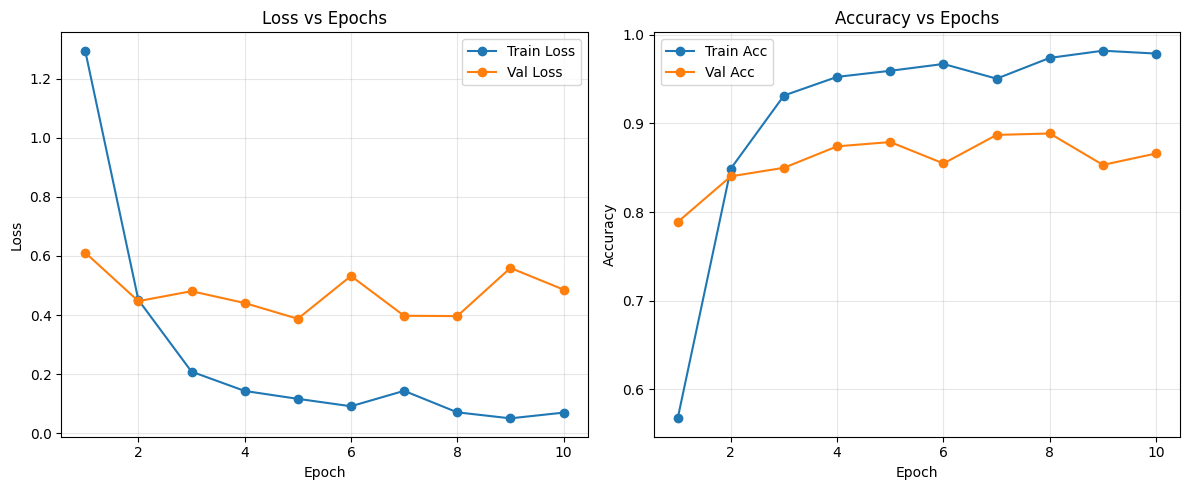

In [9]:
# === Cell 12 (updated): Train loop with metric logging for Part B analysis ===
import matplotlib.pyplot as plt
import json
import os

def train_model(model, model_name=model_name, epochs=NUM_EPOCHS, save_dir="../pooled_models"):
    """
    Full training loop.
    Tracks metrics for Part B analysis (loss/accuracy/F1 per epoch)
    and saves best model based on validation F1-score.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    best_f1 = 0.0
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": []
    }

    for epoch in range(1, epochs + 1):
        print(f"\n🟢 Epoch {epoch}/{epochs}")
        
        # ---- Training ----
        tr_loss, tr_acc = train_one_epoch(model, train_loader)
        # ---- Validation ----
        val_loss, val_acc, val_f1 = evaluate(model, val_loader)

        # log metrics
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # display summary
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # save checkpoint if F1 improved
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_path = os.path.join(save_dir, f"{model_name}_best.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model to {save_path} (F1={best_f1:.4f})")

    # ---- Save metrics for Part B analysis ----
    hist_path = os.path.join(save_dir, f"{model_name}_history.json")
    with open(hist_path, "w") as f:
        json.dump(history, f, indent=2)
    print(f"\n📊 Training history saved at: {hist_path}")

    # ---- Plot Loss and Accuracy curves for Part B ----
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history["epoch"], history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["epoch"], history["val_loss"], label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history["epoch"], history["train_acc"], label="Train Acc", marker='o')
    plt.plot(history["epoch"], history["val_acc"], label="Val Acc", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return history

# === Example run ===
# Train Model A (e.g., DeiT Tiny)
# history_a = train_model(model, model_name=model_name, epochs=NUM_EPOCHS)

# Later you can train another model for Part B comparison, e.g.:
#model_b = build_model("vit_tiny_patch16_224", num_classes=len(train_ds.classes))
history_b = train_model(model, model_name=model_name, epochs=NUM_EPOCHS)


Before running below make sure you ran above using both models


=== Evaluating deit_tiny_patch16_224 from ../pooled_models/deit_tiny_patch16_224_best.pth ===
Checkpoint pos_embed: tokens=37, grid=6x6 (patches=36)
Loaded checkpoint into model -> missing keys: 0, unexpected keys: 0

Classification report:
              precision    recall  f1-score   support

         Cup      0.841     0.925     0.881        40
  calculator      0.958     0.821     0.885        28
         cap      0.780     0.800     0.790        40
   earphones      0.891     0.613     0.726        80
    keyboard      0.901     1.000     0.948        64
       mouse      0.880     0.848     0.864       112
     scissor      1.000     0.941     0.970        17
    sneakers      0.753     0.992     0.856       120
    umbrella      0.800     0.667     0.727        12
  wristwatch      0.914     0.794     0.850       107

    accuracy                          0.852       620
   macro avg      0.872     0.840     0.850       620
weighted avg      0.861     0.852     0.848       620


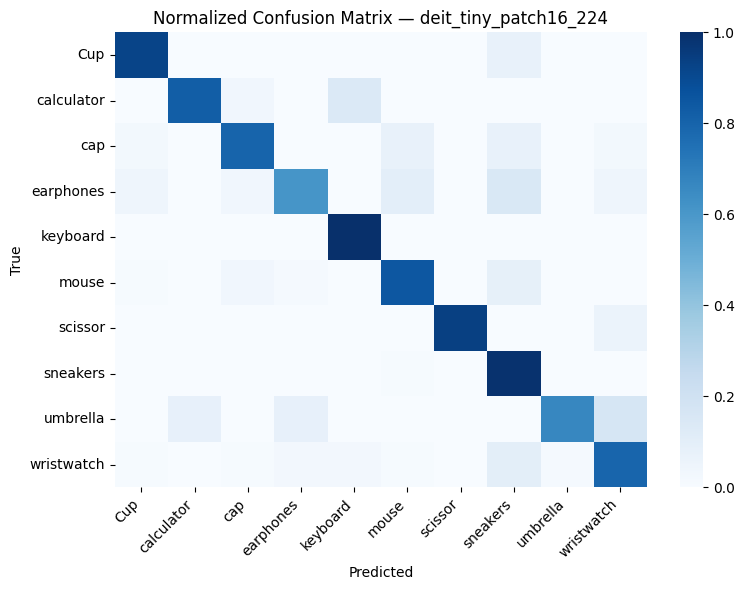


=== Evaluating vit_tiny_patch16_224 from ../pooled_models/vit_tiny_patch16_224_best.pth ===
Checkpoint pos_embed: tokens=37, grid=6x6 (patches=36)
Loaded checkpoint into model -> missing keys: 0, unexpected keys: 0

Classification report:
              precision    recall  f1-score   support

         Cup      0.897     0.875     0.886        40
  calculator      0.962     0.893     0.926        28
         cap      0.829     0.850     0.840        40
   earphones      0.946     0.662     0.779        80
    keyboard      0.926     0.984     0.955        64
       mouse      0.840     0.938     0.886       112
     scissor      0.941     0.941     0.941        17
    sneakers      0.917     0.925     0.921       120
    umbrella      0.800     0.333     0.471        12
  wristwatch      0.811     0.925     0.865       107

    accuracy                          0.879       620
   macro avg      0.887     0.833     0.847       620
weighted avg      0.883     0.879     0.875       620



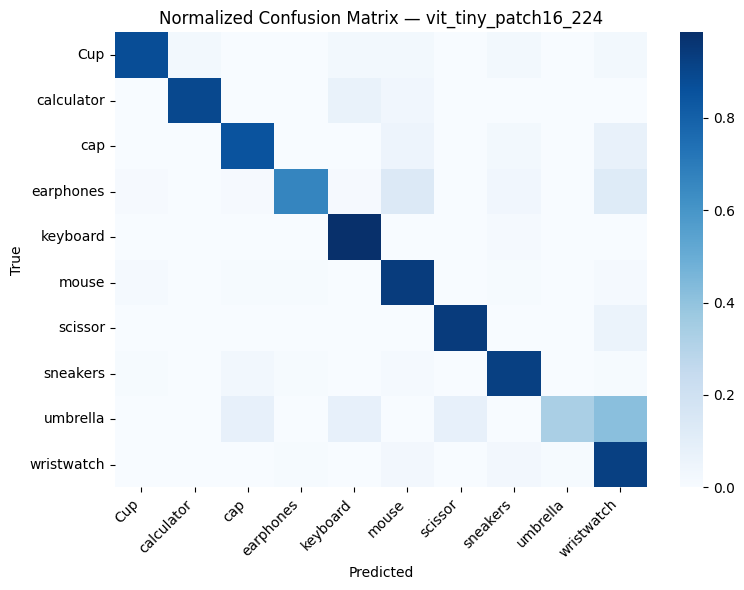

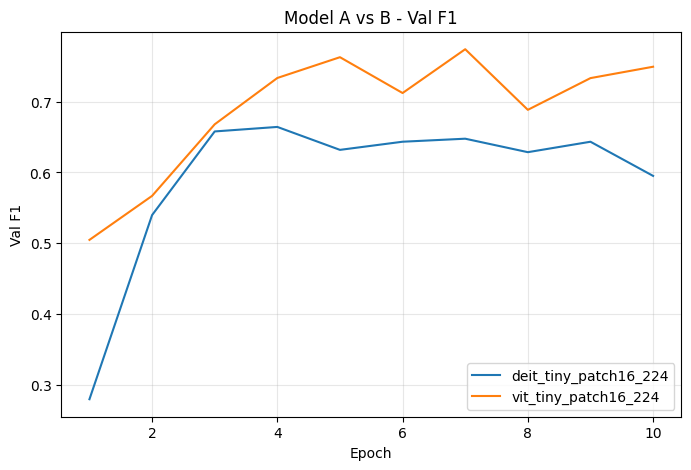

In [10]:
# === Cell 13 (robust fix): Load checkpoint safely (pos_embed auto-match) + evaluate ===
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json
import timm

def load_checkpoint_state(checkpoint_path):
    """
    Load a checkpoint and normalize to a raw state_dict (mapping param_name -> tensor).
    Accepts checkpoints that are either:
      - raw state_dict
      - dict with 'state_dict' key
      - dict with 'model' key
    """
    ck = torch.load(checkpoint_path, map_location='cpu')
    if isinstance(ck, dict):
        # common wrappers
        if 'state_dict' in ck:
            state = ck['state_dict']
        elif 'model' in ck:
            state = ck['model']
        else:
            # assume ck is already a state_dict
            state = ck
    else:
        raise RuntimeError("Checkpoint format not recognized.")
    return state

def find_pos_embed_key(state):
    """Find the key name for positional embeddings inside a state_dict."""
    for k in state.keys():
        if k.endswith('pos_embed') or k.endswith('.pos_embed') or 'pos_embed' in k:
            return k
    return None

def build_model_matching_checkpoint(model_name, num_classes, checkpoint_path, device):
    """
    Builds a timm model, adjusts its patch_embed img_size and pos_embed to match the checkpoint,
    then loads the state dict (with strict=False).
    Returns the loaded model (on device) and the state dict used.
    """
    assert os.path.exists(checkpoint_path), f"Checkpoint not found: {checkpoint_path}"
    state = load_checkpoint_state(checkpoint_path)
    pos_key = find_pos_embed_key(state)
    if pos_key is None:
        raise RuntimeError("Could not find pos_embed in checkpoint state dict keys.")
    ck_pos = state[pos_key]  # tensor, shape [1, N_tokens, dim]
    if not isinstance(ck_pos, torch.Tensor):
        ck_pos = torch.tensor(ck_pos)
    n_tokens_ckpt = ck_pos.shape[1]
    n_patches_ckpt = n_tokens_ckpt - 1
    old_grid = int(sqrt(n_patches_ckpt))
    # assume patch_size 16 unless model.patch_embed.patch_size tells otherwise later
    print(f"Checkpoint pos_embed: tokens={n_tokens_ckpt}, grid={old_grid}x{old_grid} (patches={n_patches_ckpt})")
    # Build model (no pretrained weights; we'll load from checkpoint)
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    # Infer patch size from model (could be int or tuple)
    psize = model.patch_embed.patch_size
    if isinstance(psize, tuple):
        psize = psize[0]
    # compute image size that corresponds to ckpt grid
    img_size_ckpt = old_grid * psize
    # set model.patch_embed attributes to match checkpoint
    try:
        model.patch_embed.img_size = (img_size_ckpt, img_size_ckpt)
    except Exception:
        # some timm variants may not have attribute - set if possible
        pass
    try:
        model.patch_embed.num_patches = n_patches_ckpt
    except Exception:
        pass
    # Now ensure model.pos_embed matches ckpt shape by replacing model.pos_embed param
    # with a tensor of same shape as ckpt's pos_embed (so load_state_dict won't complain)
    # But keep dtype/device consistent
    ck_pos = ck_pos.to(torch.get_default_dtype())
    # Create new pos_embed param in model with shape equal to ck_pos
    with torch.no_grad():
        model_pos_shape = list(ck_pos.shape)
        # create parameter and set to ckpt pos (we'll let load_state_dict override other weights)
        model.pos_embed = nn.Parameter(ck_pos.clone())
    # Now load state_dict with strict=False (we already matched pos_embed shape)
    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"Loaded checkpoint into model -> missing keys: {len(missing)}, unexpected keys: {len(unexpected)}")
    if len(missing) > 0:
        # print summary of missing/unexpected (short)
        print("Examples missing keys:", missing[:10])
    if len(unexpected) > 0:
        print("Examples unexpected keys:", unexpected[:10])
    model.to(device)
    model.eval()
    return model, state

def evaluate_checkpoint(model_name, checkpoint_path, device=DEVICE):
    print(f"\n=== Evaluating {model_name} from {checkpoint_path} ===")
    model, state = build_model_matching_checkpoint(model_name, num_classes=len(train_ds.classes), checkpoint_path=checkpoint_path, device=device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    # metrics
    print("\nClassification report:")
    print(classification_report(all_labels, all_preds, target_names=train_ds.classes, digits=3))
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes, annot=False)
    plt.title(f"Normalized Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return all_labels, all_preds, cm

# === MAIN: evaluate both models using stable loader ===
model_a_name = model_a   # change if your saved names differ
model_b_name = model_b

ckpt_a = f"../pooled_models/{model_a_name}_best.pth"
ckpt_b = f"../pooled_models/{model_b_name}_best.pth"

# Evaluate model A
if os.path.exists(ckpt_a):
    labels_a, preds_a, cm_a = evaluate_checkpoint(model_a_name, ckpt_a, device=DEVICE)
else:
    print(f"Model A checkpoint not found at {ckpt_a}")

# Evaluate model B
if os.path.exists(ckpt_b):
    labels_b, preds_b, cm_b = evaluate_checkpoint(model_b_name, ckpt_b, device=DEVICE)
else:
    print(f"Model B checkpoint not found at {ckpt_b}")

# --- Compare validation F1 curves if histories exist ---
hist_a_path = f"../images_models/{model_a_name}_history.json"
hist_b_path = f"../images_models/{model_b_name}_history.json"
if os.path.exists(hist_a_path) and os.path.exists(hist_b_path):
    hist_a = json.load(open(hist_a_path))
    hist_b = json.load(open(hist_b_path))
    plt.figure(figsize=(8,5))
    plt.plot(hist_a["epoch"], hist_a["val_f1"], label=f"{model_a_name}")
    plt.plot(hist_b["epoch"], hist_b["val_f1"], label=f"{model_b_name}")
    plt.xlabel("Epoch"); plt.ylabel("Val F1"); plt.title("Model A vs B - Val F1")
    plt.legend(); plt.grid(alpha=0.3); plt.show()
else:
    print("One or both history JSONs missing; skipping F1-curve comparison.")


Checkpoint pos_embed: tokens=37, grid=6x6 (patches=36)
Loaded checkpoint into model -> missing keys: 0, unexpected keys: 0
Checkpoint pos_embed: tokens=37, grid=6x6 (patches=36)
Loaded checkpoint into model -> missing keys: 0, unexpected keys: 0


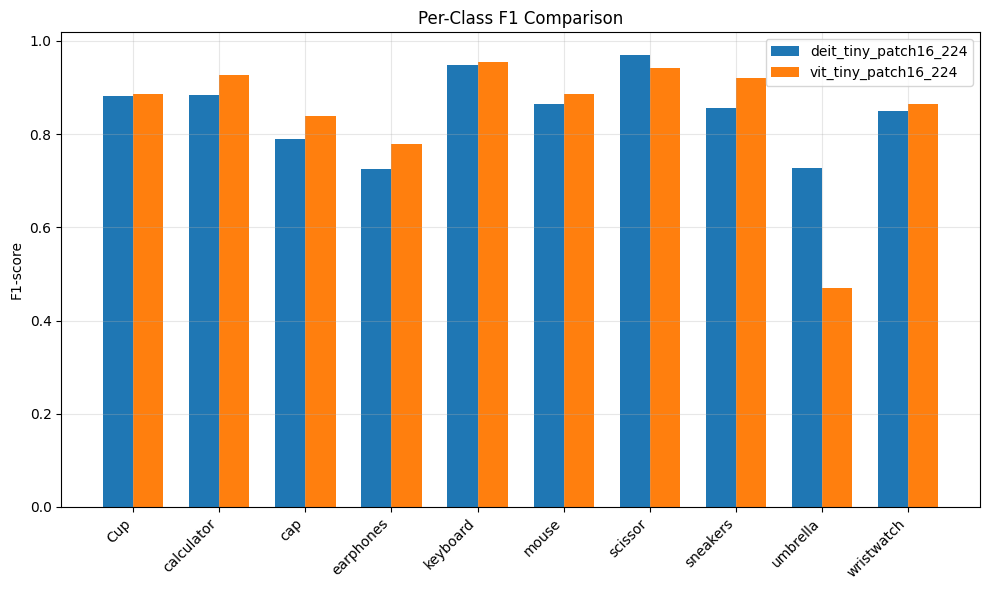

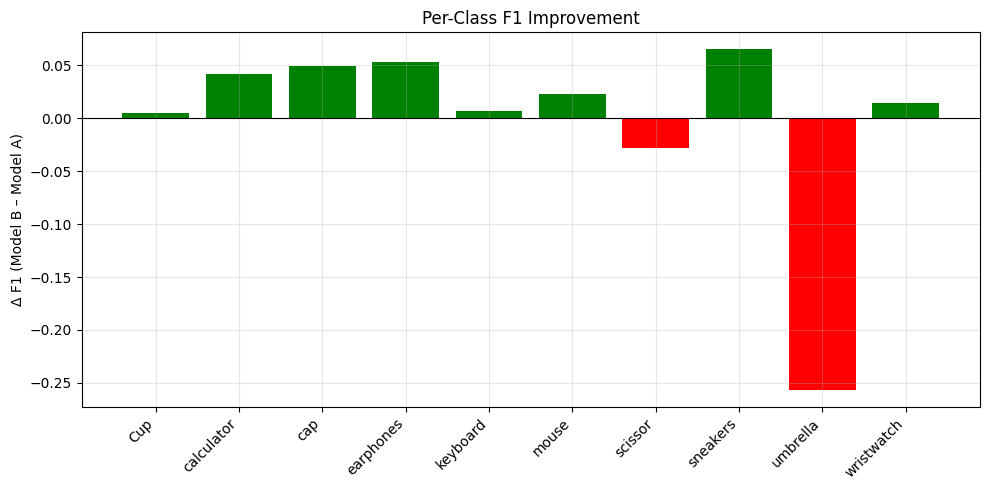

In [11]:
# === Cell 14: Per-class F1 comparison between Model A and B ===
import json
import matplotlib.pyplot as plt
import numpy as np

# model names (must match your trained ones)
model_a_name = model_a
model_b_name = model_b

# load classification reports saved earlier (re-compute if needed)
def get_class_f1_from_report(model_name, report_dict):
    """
    Extracts per-class F1 scores from classification_report output.
    Returns dict: {class_name: f1_score}
    """
    f1 = {}
    for k, v in report_dict.items():
        if k in train_ds.classes:     # only keep valid class names
            f1[k] = v["f1-score"]
    return f1

# regenerate reports if not saved previously
from sklearn.metrics import classification_report

def recompute_report(model_name):
    best_path = f"../pooled_models/{model_name}_best.pth"
    model, _ = build_model_matching_checkpoint(model_name, len(train_ds.classes), best_path, DEVICE)
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(labels.numpy())
    rep = classification_report(labels_all, preds_all,
                                target_names=train_ds.classes, output_dict=True)
    return rep

# Evaluate or load both reports
report_a = recompute_report(model_a_name)
report_b = recompute_report(model_b_name)

f1_a = get_class_f1_from_report(model_a_name, report_a)
f1_b = get_class_f1_from_report(model_b_name, report_b)

# sort classes alphabetically for consistent plotting
classes = train_ds.classes
f1_a_vals = [f1_a.get(c, 0) for c in classes]
f1_b_vals = [f1_b.get(c, 0) for c in classes]

# improvement per class
improvement = np.array(f1_b_vals) - np.array(f1_a_vals)

# --- Plot ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(classes))

# side-by-side bars
plt.bar(x - bar_width/2, f1_a_vals, width=bar_width, label=f"{model_a_name}")
plt.bar(x + bar_width/2, f1_b_vals, width=bar_width, label=f"{model_b_name}")
plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("F1-score")
plt.title("Per-Class F1 Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Improvement plot (Model B – Model A) ---
plt.figure(figsize=(10,5))
colors = ['green' if d >= 0 else 'red' for d in improvement]
plt.bar(classes, improvement, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Δ F1 (Model B – Model A)")
plt.title("Per-Class F1 Improvement")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


| Color                 | Meaning                                |
| --------------------- | -------------------------------------- |
| 🟩 Green bar          | Model B performed better on that class |
| 🟥 Red bar            | Model B performed worse on that class  |
| F1 side-by-side chart | Shows absolute performance per class   |
